In [3]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [4]:
df = pd.read_csv('/content/train.txt',
                 delimiter=';', header=None, names=['sentence','label'])
df.tail()

,sentence,label
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger
15999,i know a lot but i feel so stupid because i ca...,sadness


In [5]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [6]:
df.label.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [7]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')
df_baru.tail()

,sentence,anger,fear,joy,love,sadness,surprise
15995,i just had a very brief time in the beanbag an...,0,0,0,0,1,0
15996,i am now turning and i feel pathetic that i am...,0,0,0,0,1,0
15997,i feel strong and good overall,0,0,1,0,0,0
15998,i feel like this was such a rude comment and i...,1,0,0,0,0,0
15999,i know a lot but i feel so stupid because i ca...,0,0,0,0,1,0


In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
def Tahapan_Stopword(text):
  # tokenisasi teks
  words = word_tokenize(text) # Konversi text ke kata-kata

  # hapus stopwoerd
  stop_words = set(stopwords.words('english')) # Menghapus kata kaya yang tidak punya makna
  words = [word for word in words if word.lower() not in stop_words]

  return ' '.join(words)

def Tahapan_Stemming(text):
  stemmer = PorterStemmer()
  words = word_tokenize(text)

  stemmed_words = [stemmer.stem(word) for word in words] # Mereduksi kata-kata ke bentuk dasar
  return ' '.join(stemmed_words)

In [10]:
df_baru['Stopwords'] = df_baru['sentence'].apply(Tahapan_Stopword)
df_baru['Stemming'] = df_baru['Stopwords'].apply(Tahapan_Stemming)
df_baru.tail()

,sentence,anger,fear,joy,love,sadness,surprise,Stopwords,Stemming
15995,i just had a very brief time in the beanbag an...,0,0,0,0,1,0,brief time beanbag said anna feel like beaten,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,0,0,0,0,1,0,turning feel pathetic still waiting tables sub...,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,0,0,1,0,0,0,feel strong good overall,feel strong good overal
15998,i feel like this was such a rude comment and i...,1,0,0,0,0,0,feel like rude comment im glad,feel like rude comment im glad
15999,i know a lot but i feel so stupid because i ca...,0,0,0,0,1,0,know lot feel stupid portray,know lot feel stupid portray


In [11]:
kalimat = df_baru['Stemming'].values
label = df_baru[['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']].values

In [12]:
kalimat_latih, kalimat_test, label_latih, label_test = train_test_split(kalimat, label, test_size=0.2)

In [13]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(kalimat_latih)
tokenizer.fit_on_texts(kalimat_test)

sekuens_latih = tokenizer.texts_to_sequences(kalimat_latih)
sekuens_test = tokenizer.texts_to_sequences(kalimat_test)

padded_latih = pad_sequences(sekuens_latih, maxlen=30)
padded_test = pad_sequences(sekuens_test, maxlen=30)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') is not None and logs.get('accuracy') > 0.9) and \
           (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.85):
            print('\nAkurasi pada data latih telah mencapai > 90% ')
            self.model.stop_training = True

In [16]:
num_epochs = 50
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2,
                    callbacks=[myCallback(), early_stopping])

Epoch 1/50
400/400 - 35s - loss: 1.4515 - accuracy: 0.3631 - val_loss: 1.1798 - val_accuracy: 0.4334 - 35s/epoch - 88ms/step
Epoch 2/50
400/400 - 26s - loss: 1.0643 - accuracy: 0.4703 - val_loss: 1.0124 - val_accuracy: 0.5300 - 26s/epoch - 64ms/step
Epoch 3/50
400/400 - 23s - loss: 0.8797 - accuracy: 0.6113 - val_loss: 0.8223 - val_accuracy: 0.7097 - 23s/epoch - 57ms/step
Epoch 4/50
400/400 - 23s - loss: 0.5423 - accuracy: 0.8231 - val_loss: 0.5530 - val_accuracy: 0.8103 - 23s/epoch - 58ms/step
Epoch 5/50
400/400 - 25s - loss: 0.3181 - accuracy: 0.8963 - val_loss: 0.4779 - val_accuracy: 0.8566 - 25s/epoch - 61ms/step
Epoch 6/50

Akurasi pada data latih telah mencapai > 90% 
400/400 - 24s - loss: 0.2076 - accuracy: 0.9356 - val_loss: 0.4775 - val_accuracy: 0.8700 - 24s/epoch - 60ms/step


In [17]:
def plot_acc_loss(history):
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].set_title('Loss')
  ax[0].plot(history.epoch, history.history['loss'],label = 'Train Loss')
  ax[0].plot(history.epoch, history.history['val_loss'],label = 'Valid Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].plot(history.epoch, history.history['accuracy'],label = 'Train Accuracy')
  ax[1].plot(history.epoch, history.history['val_accuracy'],label = 'Valid Accuracy')
  ax[1].legend()

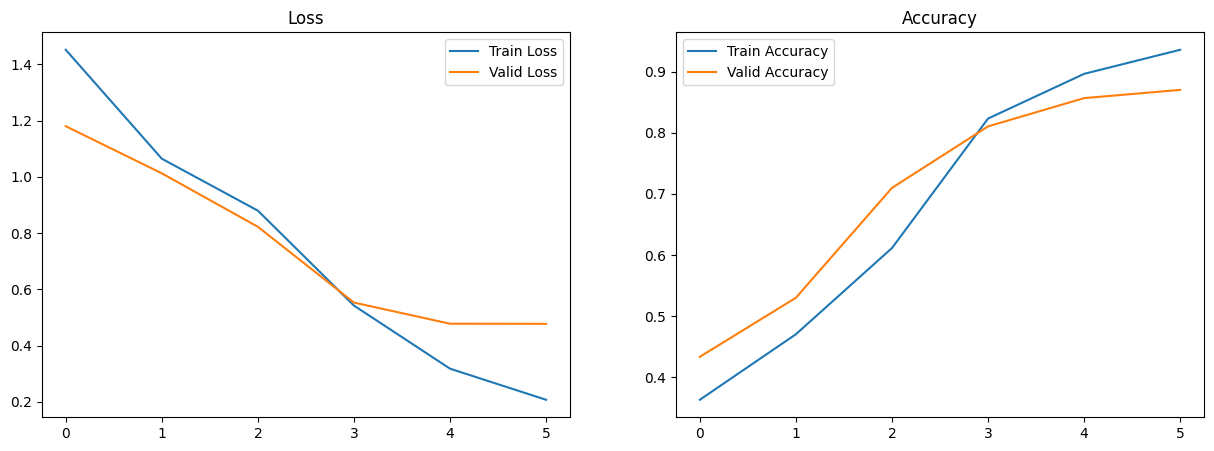

In [18]:
plot_acc_loss(history)

In [19]:
# Save model
import pickle
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('nlp.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model
    import numpy as np

    # Load the trained model and tokenizer
    model = load_model(model_path)
    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)

    # Preprocess the text
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)

    # Make a prediction
    predictions = model.predict(x_new)[0]

    # Define the emotion labels
    emotions = {0: 'love', 1: 'anger', 2: 'fear', 3:'joy', 4:'sadness', 5:'suprise'}
    labels = list(emotions.values())
    probs = list(predictions)

    # Print the predicted emotion and its probability
    print(f"\nYour text: '{text}'")
    print(f"Predicted emotion: {labels[np.argmax(probs)]} with a probability of {np.max(probs)*100:.2f}%\n")

    # Plot the probabilities
    plt.figure(figsize=(7,4))
    plt.barh(labels, probs, color='skyblue')
    plt.xlabel('Probability', fontsize=15)
    plt.title('Emotion Prediction Probabilities', fontsize=15)
    plt.xlim(0,1)
    for i, v in enumerate(probs):
        plt.text(v, i, f" {v*100:.2f}%", color='black', va='center', fontweight='bold')
    plt.show()

Input text : i feel a little nervous i go to the gym
1/1 [==============================] - 3s 3s/step

Your text: 'i feel a little nervous i go to the gym'
Predicted emotion: fear with a probability of 86.40%



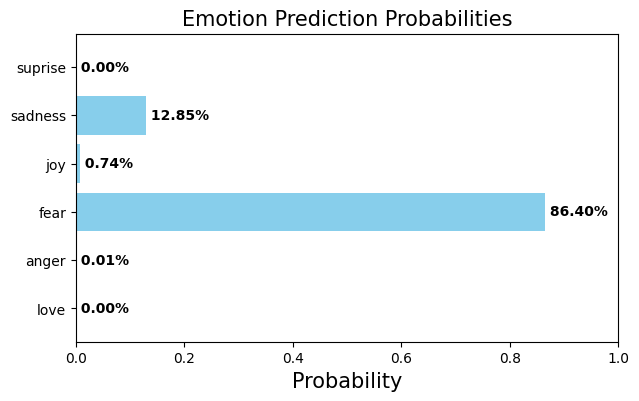

In [77]:
txt = str(input('Input text : '))
predict(txt, 'nlp.h5', 'tokenizer.pkl')